<h1>Introduction</h1>
Ice Games sells video games worldwide, specifically in three markets (plus an "Other" market category). This analysis looks at data in various markets for sales in the year 2016 and provides some conclusions based on that data that will be useful for  making decisions in 2017.

These are the different libraries that are necessary to complete the analysis.

In [146]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
from math import factorial as ft 
import plotly.express as px
plt.style.use('ggplot')

This reads the data into a DataFrame and displays information regarding the data and the first five rows of the data.

In [147]:
ice_data = pd.read_csv('/Users/leahdeyoung/Desktop/GitHub/ice-games-practicum/moved_games.csv', encoding = "utf-8")

display(ice_data.head())
ice_data.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<h2>Data PreProcessing</h2>

This code checks for any fully duplicate rows. There appear to be none.

In [148]:
print(ice_data.duplicated().sum())

0


This code replaced all the column names with the lowercase version of the name.

In [149]:
ice_data.columns = ice_data.columns.str.lower()
print(ice_data.columns)
print(ice_data.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')
Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


This code checks for duplicates in the name data by converting all the names to lowercase values and dropping any duplicates that also have a duplicate year of release and platform. This is because some games have new releases in different years and games could be released on different platforms.

In [150]:
ice_data.info()
print(ice_data['name'].value_counts())
print(ice_data['name'].unique())
ice_data['name_lowercase'] = ice_data['name'].str.lower()
print(ice_data['name'].value_counts())
print(ice_data['name_lowercase'].unique())
print(ice_data.duplicated(subset=['name_lowercase', 'year_of_release', 'platform']).sum())
ice_data = ice_data.drop_duplicates(subset=['name_lowercase', 'year_of_release', 'platform']).reset_index(drop=True)

ice_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
Need for Speed: Most Wanted                         12
Ratatouille                                          9
LEGO Marvel Super Heroes                             9
FIFA 14                                              9
Madden NFL 07        

This code checks for names that are missing, then grabs the rows where the name is missing to view for analysis.

It looks like quite a bit of information is missing about this row; however, there were in fact sales in Europe and North America for this game, and the platform is valid and used for other games. Therefore, I decided to keep the row and add the string "Unknown Name" to the name field.

In [151]:
print(ice_data['name'].isna().sum())
print(ice_data.query("name.isna()"))
print(ice_data['platform'].value_counts().head(25))
ice_data['name'] = ice_data['name'].fillna('Unknown Name')
print(ice_data['name'].isna().sum())


1
    name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659  NaN      GEN           1993.0   NaN      1.78      0.53       0.0   

     other_sales  critic_score user_score rating name_lowercase  
659         0.08           NaN        NaN    NaN            NaN  
PS2     2161
DS      2151
PS3     1330
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       28
NG        12
Name: platform, dtype: int64
0


I looked at sample rows that are missing the year of release and I noticed that some have the year in the name field. For those rows, I used the year listed in the name to fill the year of release. For the other rows, I replaced the missing year of release with median year of release. For all rows I converted the datatype to datetime and made sure to isolate just the year.

In [152]:
print(ice_data['year_of_release'].isna().sum())

#fill year from name
ice_data['year_of_release'] = ice_data['year_of_release'].where(ice_data['name'] != 'PES 2009: Pro Evolution Soccer', 2009)
ice_data['name_year'] = ice_data.query("year_of_release.isna() and (name.str.contains('200') or name.str.contains('19'))")['name'].str[-4:]
ice_data['year_of_release'] = ice_data['year_of_release'].where((ice_data['year_of_release'].notna() & ice_data['name_year'].isna()), ice_data['name_year'])

#check work
print(ice_data['year_of_release'].isna().sum())

#fill missing fields by median
year_median = ice_data['year_of_release'].median()
year_median = round(year_median, 0)
ice_data['year_of_release'] = ice_data['year_of_release'].where((ice_data['year_of_release'].notna()) , year_median) 

#convert datatype
ice_data['year_of_release'] = ice_data['year_of_release'].astype(int)
ice_data['year_of_release'] = pd.to_datetime(ice_data['year_of_release'], format='%Y')
ice_data['year_of_release'] = ice_data['year_of_release'].dt.year

#check work
print(ice_data['year_of_release'].isna().sum())



269
254
0


This code checks for genres that are missing, then grabs the rows where the genre is missing to view for analysis.

It looks like this is the same row that was missing the name. Based on my previous analysis, I decided to keep the row and add the string "Unknown Genre" to the genre field.

In [153]:
print(ice_data['genre'].isna().sum())
print(ice_data.query("genre.isna()"))
ice_data['genre'] = ice_data['genre'].fillna('Unknown Genre')
print(ice_data['genre'].isna().sum())


1
             name platform  year_of_release genre  na_sales  eu_sales  \
659  Unknown Name      GEN             1993   NaN      1.78      0.53   

     jp_sales  other_sales  critic_score user_score rating name_lowercase  \
659       0.0         0.08           NaN        NaN    NaN            NaN   

    name_year  
659       NaN  
0


I looked at sample rows that are missing the critic score and I did not see any pattern. It is likely these are simply games that did not have a critic score yet.  This code converts existing values to float.

In [154]:
#view data and compare
print(ice_data['critic_score'].isna().sum())
#print(ice_data.query("critic_score.isna()").sample(5))
print(ice_data.query("critic_score.isna() and user_score.notna()")['name'].count())

#convert non-null values to float
ice_data['critic_score'] = pd.to_numeric(ice_data['critic_score'], errors='coerce')

#check work
print(ice_data['critic_score'].dtypes)

print(ice_data['critic_score'].isna().sum())
print(ice_data['critic_score'].unique())


8577
1915
float64
8577
[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 35. 41. 36.
 28. 31. 27. 26. 19. 23. 24. 21. 17. 22. 13.]


I looked at sample rows that are missing the rating, and I noticed that any game that is missing a rating is also missing a user score, but I am actually not sure if there is a conclusion to be drawn there. The code then fills blank values with "Rating Unknown".

In [155]:
print(ice_data['rating'].isna().sum())
print(ice_data.query("rating.isna()").sample(5))
print(ice_data.query("rating.isna() and user_score.notna()")['name'].count())
ice_data['rating'] = ice_data['rating'].fillna('Rating Unknown')
print(ice_data['rating'].isna().sum())

6765
                                          name platform  year_of_release  \
15981             Achtung Panzer: Kharkov 1943       PC             2010   
5196                      Kirby's Dream Land 3     SNES             1997   
4518                             Cool Boarders       PS             1996   
14312  Tamagotchi no Doki Doki Dream Omisecchi      3DS             2013   
15087                                 Canvas 2      PS2             2006   

            genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
15981    Strategy       0.0      0.01      0.00         0.00          70.0   
5196     Platform       0.0      0.00      0.36         0.00           NaN   
4518       Sports       0.1      0.07      0.24         0.03           NaN   
14312  Simulation       0.0      0.00      0.03         0.00           NaN   
15087   Adventure       0.0      0.00      0.02         0.00           NaN   

      user_score rating                           name_lowercase name

Two of the rows has a user score of "tbd". I am guessing that this means that a user has not giving this a score or user rating yet. To mitigate this, I averaged all the unique ratings values together and replaced the "tbd" values with this average, rounded to one decimal. The remaining code converts all non-null values to float.

In [156]:
print(ice_data['user_score'].isna().sum())
print(ice_data['user_score'].unique())
#print(ice_data.query("user_score == 'tbd'"))

#calculate overall user_score mean to replace "tbd" value
user_score_dropna = ice_data['user_score'].dropna()
score_list = list(user_score_dropna.unique())
score_list.remove('tbd')
score_float_list = [float(score) for score in score_list]
score_mean = sum(score_float_list) / len(score_float_list)
score_mean = round(score_mean, 1)
ice_data['user_score'] = ice_data['user_score'].where((ice_data['user_score'] != 'tbd') , score_mean) 
print(ice_data['user_score'].unique())

#convert non-null values to float
ice_data['user_score'] = pd.to_numeric(ice_data['user_score'], errors='coerce')
#check work
print(ice_data['user_score'].dtypes)
print(ice_data['user_score'].isna().sum())
print(ice_data['user_score'].unique())

6700
['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']
['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 5.0 '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2

This code creates a total sales column and adds the three regions plus the "other sales" together to determine the value

In [157]:
ice_data['total_sales'] = ice_data['na_sales'] + ice_data['eu_sales'] + ice_data['jp_sales'] + ice_data['other_sales']

This code drops all the extra columns created to preprocess the data.

In [158]:
ice_data.drop(['name_lowercase', 'name_year'], axis=1, inplace=True)



This code checks the info on the dataframe and a random ten rows of the DataFrame

In [159]:
ice_data.info()
display(ice_data.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
12580,World Cup of Pool,DS,2009,Sports,0.06,0.00,0.0,0.00,NaN,5.0,E,0.06
2086,Guitar Hero: Aerosmith,PS3,2008,Misc,0.73,0.15,0.0,0.11,70.0,5.0,T,0.99
16239,NHL 16,PS3,2015,Sports,0.00,0.01,0.0,0.00,NaN,NaN,Rating Unknown,0.01
1084,SSX 3,PS2,2003,Sports,0.93,0.52,0.0,0.22,93.0,9.1,E,1.67
1206,Guitar Hero 5,Wii,2009,Misc,0.92,0.48,0.0,0.15,89.0,6.9,T,1.55
3719,Pachi-Slot Aruze Oukoku 2,PS,1999,Misc,0.00,0.00,0.5,0.04,NaN,NaN,Rating Unknown,0.54
11039,Astro Boy: Omega Factor,GBA,2003,Action,0.06,0.02,0.0,0.00,85.0,8.6,E,0.08
11124,Pipe Mania,DS,2008,Puzzle,0.08,0.01,0.0,0.01,71.0,5.0,E,0.10
14159,Infamous: First Light,PS4,2014,Action,0.00,0.03,0.0,0.00,73.0,7.5,T,0.03
12859,Roogoo Twisted Towers,Wii,2009,Puzzle,0.05,0.00,0.0,0.00,NaN,NaN,Rating Unknown,0.05


<h2>Data Analysis</h2>

Look at how many games were released in different years. Is the data for every period significant?

In [160]:
games_per_year = ice_data.groupby('year_of_release')['name'].count()

games_per_year = ice_data.groupby('year_of_release')['name'].count()
games_per_year = games_per_year.reset_index().rename(columns={0: 'year_of_release', 'name': 'name'})
games_per_year_bar = px.bar(games_per_year,
                                x='year_of_release',
                                y='name',
                                #color='year_of_release',
                                labels={
                                        'year_of_release': 'Year of Release',
                                        ' Name': 'Number of Games'},
                                title='Number of Games Released in a Given Year')

#print(games_per_year)
games_per_year_bar.show()

It looks the data starts to be significant in 2000, when the count is over 100. It could be that the relevant data did not start to be reported consistently before that time.

Look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data for each year. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?

In [161]:
#create bar chart of all total sales
grp = ice_data.groupby(['platform'])
sales_per_platform = grp['total_sales'].sum()
sales_per_platform = sales_per_platform.reset_index().rename(columns={0: 'platform', 'total_sales': 'total_sales'})
sales_platform_bar = px.bar(sales_per_platform,
                            x='platform',
                            y='total_sales',
                            labels={
                                    'platform': 'Platform',
                                    'total_sales': 'Total Sales (in USD millions)',
                                    },                              
                            title='Total Sales (in USD millions) per Platform')
sales_platform_bar.show()

In [162]:
#grab top platforms and create bar chat of their total sales only
grp2 = ice_data.groupby(['platform', 'year_of_release'])
annual_sales_per_platform = grp2['total_sales'].sum()
annual_sales_per_platform = annual_sales_per_platform.reset_index().rename(columns={0: 'platform', 1: 'year_of_release', 'total_sales': 'total_sales'})
sorted_by_total_sales = annual_sales_per_platform.sort_values(by='total_sales', ascending=False)
top_platforms = sorted_by_total_sales['platform'].head(20).reset_index().rename(columns={0: 'platform'})
unique_platforms = top_platforms['platform'].unique()
unique_platforms_list = list(unique_platforms)
top_sales_platform = annual_sales_per_platform[annual_sales_per_platform['platform'].isin(unique_platforms_list)]
top_sales_platform_scatter = px.scatter(top_sales_platform,
                                x='platform',
                                y='year_of_release',
                                range_y=(1992, 2016),
                                size='total_sales',
                                labels={
                                        'platform': 'Platforms with Greatest Total Sales',
                                        'total_sales': 'Total Sales (in USD millions)',
                                        'year_of_release': 'Year of Release'},                              
                                title='Total Annual Sales (in USD millions) for Platforms with Greatest Sales')

top_sales_platform_scatter.show()

In the top five platforms, platforms seem to have a lifespan of between 7 and 10 years, with most coming in at 7 and 8 years.

In [163]:
#platforms that were popular
grp3 = ice_data.groupby(['year_of_release', 'platform'])
formerly_popular = grp3['total_sales'].sum()
formerly_popular = formerly_popular.reset_index().rename(columns={0: 'year_of_release', 1: 'platform', 'total_sales': 'total_sales'})
formerly_popular_sorted = formerly_popular.sort_values(by='total_sales', ascending=False)
formerly_popular_sorted_scatter = px.scatter(formerly_popular_sorted,
                                     x='platform',
                                     y='year_of_release',
                                     color='total_sales',
                                     labels={
                                             'platform': 'Platform',
                                             'total_sales': 'Total Sales (in USD millions)',
                                             'year_of_release': 'Year of Release'},                              
                                     title="Platforms' Appearance and Disappearance in terms of Annual Total Sales (USD Millions)")

#display results
formerly_popular_sorted_scatter.show()

Determine what period you should take data for. To do so, look at your answers to the previous questions. The data should allow you to build a prognosis for 2017.

Based on the platforms with greatest sales and the platforms' appearance and disappearance throughout the years, I think it would be best to look at the period 2012-2016.  

Work only with the data that you've decided is relevant. Disregard the data for previous years.

In [164]:
ice_data_filtered = ice_data.query("year_of_release > 2011 and year_of_release < 2017").reset_index()
display(ice_data_filtered.head())

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Rating Unknown,14.63
3,33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Rating Unknown,14.60
4,34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.

In [165]:
leading_sales = ice_data_filtered.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
leading_sales = leading_sales.reset_index().rename(columns={0: 'platform', 'total_sales': 'total_sales'})
print(leading_sales)
sales_growth = ice_data_filtered.groupby(['year_of_release', 'platform'])['total_sales'].sum()
sales_growth = sales_growth.reset_index().rename(columns={0: 'year_of_release', 1: 'platform', 'total_sales': 'total_sales'})
sales_growth_chart = px.scatter(sales_growth,
                                x='platform',
                                y='year_of_release',
                                color='total_sales',
                                labels={
                                        'platform': 'Platform',
                                        'total_sales': 'Total Sales (in USD millions)',
                                        'year_of_release': 'Year of Release'},                              
                                        title="Platforms' Sales Growth (USD Millions)"
    
)

sales_growth_chart.show()

   platform  total_sales
0       PS4       314.14
1       PS3       288.78
2      X360       236.54
3       3DS       194.61
4      XOne       159.32
5      WiiU        82.19
6        PC        62.65
7       PSV        49.18
8       Wii        35.37
9        DS        12.55
10      PSP        11.19


XOne, PS4, 3DS led in sales in 2016.
PC and Wii have sharply dropped off with new streaming options on other game consoles. XBox 360 has decreased as new XBox versions have been released. Same with PS2 and PS3 now that PS4 is released.
Based on these numbers and the graph, I would say that XOne, PS4, 3DS, and potentially PSV could be profitable.


Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.

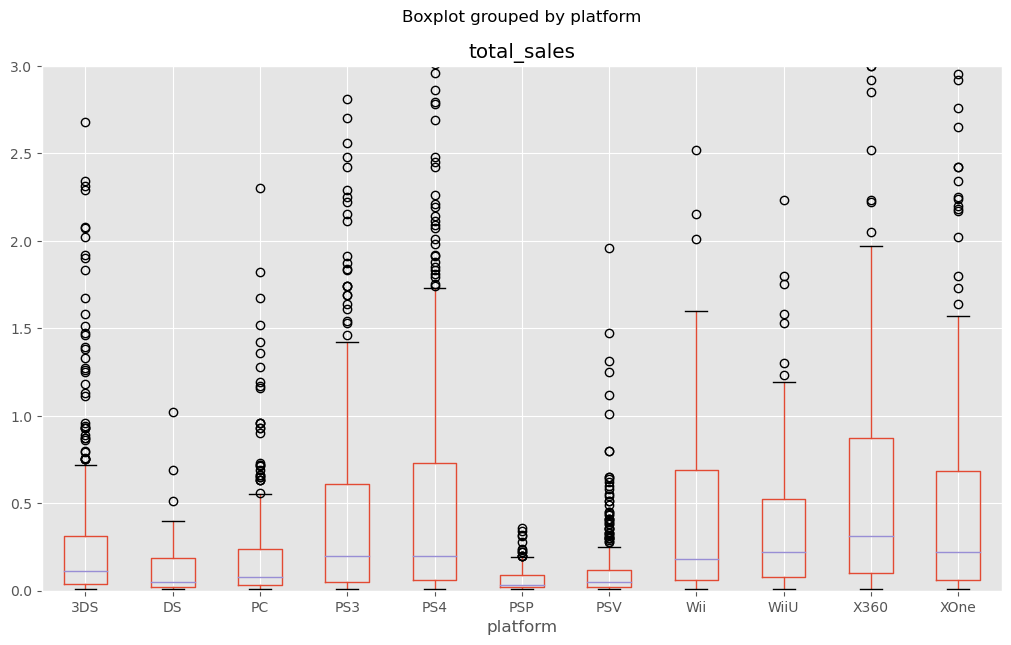

In [166]:
ice_data_filtered.boxplot('total_sales', by='platform', figsize=(12,7))
plt.ylim(0,3);


I would say that differences in sales are fairly significant. The difference between the min and max is one million. Average sales also seem to have a broad range, though most fall between $200,000 and $800,000 USD.

Looking at the outliers, they may be games that sold unusually well for the platform. It may be worth looking at these games as something to invest in.

Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.

In [176]:
#functions to compare ratings to sales
def rating_sale_comparison (dataframe, critic_scatter_title, user_scatter_title, critic_label, user_label, sale_label, name_label):
    critic_sale_scatter = px.scatter(dataframe,
                         x='critic_score',
                         y='total_sales',
                         color='name',
                         labels={
                                 'critic_score': critic_label,
                                 'total_sales': sale_label,
                                 'name': name_label},
                         title=critic_scatter_title,
                         width=1200, 
                         height=400
                         )
    critic_sale_scatter.show()
    user_scale_scatter = px.scatter(dataframe,
                         x='user_score',
                         y='total_sales',
                         color='name',
                         labels={
                                 'user_score': user_label,
                                 'total_sales': sale_label,
                                 'name': name_label},
                         title=user_scatter_title,
                         width=1200, 
                         height=400
                         )
    user_scale_scatter.show()
    return

#ps4 data comparison and correlation
ps4_data = ice_data_filtered[ice_data_filtered['platform']=='PS4']
print(ps4_data.info())
rating_sale_comparison(ps4_data, 'PS4 Total Sales (in USD millions) Relative to Critic Score', 'PS4 Total Sales (in USD millions) Relative to User Score', 'Critic Score', 'User Score', 'Total Sales (in USD millions)', 'Game')

#ice_data['user_score'] = ice_data['user_score'].where((ice_data['user_score'].notna()) , ice_data['user_score'].astype(float)) 

ps4_critic_sale_corr =ps4_data['critic_score'].corr(ps4_data['total_sales'])
ps4_user_sale_corr = ps4_data['user_score'].corr(ps4_data['total_sales'])



print('PS4 Critic Score Correlation: ' + str(ps4_critic_sale_corr))
print('PS4 User Score Correlation: ' + str(ps4_user_sale_corr))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 2 to 2833
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            392 non-null    int64  
 1   name             392 non-null    object 
 2   platform         392 non-null    object 
 3   year_of_release  392 non-null    int64  
 4   genre            392 non-null    object 
 5   na_sales         392 non-null    float64
 6   eu_sales         392 non-null    float64
 7   jp_sales         392 non-null    float64
 8   other_sales      392 non-null    float64
 9   critic_score     252 non-null    float64
 10  user_score       263 non-null    float64
 11  rating           392 non-null    object 
 12  total_sales      392 non-null    float64
dtypes: float64(7), int64(2), object(4)
memory usage: 42.9+ KB
None


PS4 Critic Score Correlation: 0.40656790206178095
PS4 User Score Correlation: -0.015969104053721258


There was not a strong correlation between user reviews and total sales. There is some positive correlation between critic reviews and total sales.

Keeping your conclusions in mind, compare the sales of the same games on other platforms.

In [177]:
xone_data = ice_data[ice_data['platform']=='XOne']
rating_sale_comparison(xone_data, 'XBox One Total Sales (in USD millions) Relative to Critic Score', 'XBox One Total Sales (in USD millions) Relative to User Score', 'Critic Score', 'User Score', 'Total Sales (in USD millions)', 'Game')

xone_critic_sale_corr = xone_data['critic_score'].corr(xone_data['total_sales'])
xone_user_sale_corr = xone_data['user_score'].corr(xone_data['total_sales'])

threeds_data = ice_data[ice_data['platform']=='3DS']
rating_sale_comparison(threeds_data, '3DS Total Sales (in USD millions) Relative to Critic Score', '3DS Total Sales (in USD millions) Relative to User Score', 'Critic Score', 'User Score', 'Total Sales (in USD millions)', 'Game')

threeds_critic_sale_corr = threeds_data['critic_score'].corr(threeds_data['total_sales'])
threeds_user_sale_corr = threeds_data['user_score'].corr(threeds_data['total_sales'])

print('XBox One Critic Score Correlation: ' + str(xone_critic_sale_corr))
print('XBox One User Score Correlation: ' + str(xone_user_sale_corr))
print('3DS Critic Score Correlation: ' + str(threeds_critic_sale_corr))
print('3DS User Score Correlation: ' + str(threeds_user_sale_corr))

XBox One Critic Score Correlation: 0.4169983280084017
XBox One User Score Correlation: -0.02507826088164102
3DS Critic Score Correlation: 0.3494009303924131
3DS User Score Correlation: 0.2869150473619056


I chose the other two platforms with top sales: 3DS and XBox One. The user scores also do not seem to have a strong correlation with total sales, but the critic scores and total sales for both XBox One and 3DS have a slightly stronger positive correlation.

Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

In [169]:
genre_sales_total = ice_data_filtered.groupby('genre')['total_sales'].sum()
genre_sales_mean = ice_data_filtered.groupby('genre')['total_sales'].mean()
genre_sales_median = ice_data_filtered.groupby('genre')['total_sales'].median()

genre_sales_total = genre_sales_total.reset_index().rename(columns={0: 'genre', 'total_sales': 'total_sales'}).sort_values(by='total_sales')
genre_sales_mean = genre_sales_mean.reset_index().rename(columns={0: 'genre', 'total_sales': 'total_sales'}).sort_values(by='total_sales')
genre_sales_median = genre_sales_median.reset_index().rename(columns={0: 'genre', 'total_sales': 'total_sales'}).sort_values(by='total_sales')

genre_sales_total_bar = px.bar(genre_sales_total,
                                x='genre',
                                y='total_sales',
                                labels={
                                        'genre': 'Genre',
                                        'total_sales': 'Total Sales (in USD millions)',
                                        },                              
                                title='Total Annual Sales (in USD millions) by Genre')

genre_sales_mean_bar = px.bar(genre_sales_mean,
                                x='genre',
                                y='total_sales',
                                labels={
                                        'genre': 'Genre',
                                        'total_sales': 'Average Sales (in USD millions)',
                                        },                              
                                title='Average Annual Sales (in USD millions) by Genre')

genre_sales_median_bar = px.bar(genre_sales_median,
                                x='genre',
                                y='total_sales',
                                labels={
                                        'genre': 'Genre',
                                        'total_sales': 'Median Sales (in USD millions)',
                                        },                              
                                title='Median Annual Sales (in USD millions) by Genre')

genre_sales_total_bar.show()
genre_sales_mean_bar.show()
genre_sales_median_bar.show()

The least profitable genres (in total, average, and median sales) are puzzle, strategy, and adventure. The most profitable are shooter, action, sports and the misc categories. If I were to generalize about them, I would say that the most profitable seem to be the most interactive and have a lot of action going on in the games, while the least profitable are more cerebral and less interactive/action-packed.

For each region (NA, EU, JP), determine:
The top five platforms. Describe variations in their market shares from region to region.
The top five genres. Explain the difference.
Do ESRB ratings affect sales in individual regions?

In [170]:
#functions to calculate top five platfroms and genres
def top_five(param, region, param_name, region_sales, title):
    parameter_sales = ice_data_filtered.groupby(param)[region].sum()    
    parameter_sales = parameter_sales.reset_index().rename(columns={0: param, region: region})
    top_five_params = parameter_sales.sort_values(by=region, ascending=False).head(5)
    top_five_params = top_five_params.reset_index().rename(columns={0: param, region: region})
    
    top_five_params_bar = px.bar(top_five_params,
                                x=param,
                                y=region,
                                labels={
                                        param: param_name,
                                        region: region_sales,
                                        },                              
                                title=title)   
    top_five_params_bar.show()
    return

In [171]:
def rating_sales(region, region_sales, ratings_region_title):
    rating_sales = ice_data_filtered.groupby('rating')[region].sum()
    rating_sales = rating_sales.reset_index().rename(columns={0: 'rating', region: region})
    ratings_bar = px.bar(rating_sales,
                                 x='rating',
                                 y=region,
                                 labels={
                                         'rating': 'Ratings',
                                         region: region_sales,
                                         },                              
                                 title=ratings_region_title)
    ratings_bar.show()
    return()

In [172]:
top_five('platform', 'jp_sales', 'Platforms', 'Sales in Japan (in USD Millions)', 'Top Five Platforms in Japan in terms of Game Sales')
top_five('platform', 'na_sales', 'Platforms', 'Sales in North America (in USD Millions)', 'Top Five Platforms in North America in terms of Game Sales')
top_five('platform', 'eu_sales', 'Platforms', 'Sales in Europe (in USD Millions)', 'Top Five Platforms in Europe in terms of Game Sales')

top_five('genre', 'jp_sales', 'Genres', 'Sales in Japan (in USD Millions)', 'Top Five Genres in Japan in terms of Game Sales')
top_five('genre', 'na_sales', 'Genres', 'Sales in North America (in USD Millions)', 'Top Five Genres in North America in terms of Game Sales')
top_five('genre', 'eu_sales', 'Genres', 'Sales in Europe (in USD Millions)', 'Top Five Genres in Europe in terms of Game Sales')

PS3, Nintendo DS, and Wii appear in all three markets, but the other platforms vary slightly. I think this is indicative that these three platforms were popular worldwide in 2016.

North America and Europe were very similar in their popular genres, with only the fifth-most-popular being different (Racing vs. Role-Playing). For Japan, the only two that were very similar (disregarding Misc., which is fairly generic), were Action and Sports.

In [173]:
rating_sales('jp_sales', 'Sales in Japan (in USD Millions)', 'Effect of Game Rating on Sales in Japan')
rating_sales('na_sales', 'Sales in North America (in USD Millions)', 'Effect of Game Rating on Sales in North America')
rating_sales('eu_sales', 'Sales in Europe (in USD Millions)', 'Effect of Game Rating on Sales in Europe')

()

It seems that game rating does indeed affect sales in each region differently, but in all three regions, "E"-rated  and "M"-rated games sell the most. 

Test the following hypotheses:
—Average user ratings of the Xbox One and PC platforms are the same.
—Average user ratings for the Action and Sports genres are different.
Set the alpha threshold value yourself.

In [174]:
#Null Hypothesis: Average user ratings of the Xbox One and PC platforms are not different.
#Alternative Hypothesis: Average user ratings of the Xbox One and PC platforms are different.
alpha = .05

results = st.ttest_ind(ice_data_filtered[ice_data_filtered['platform'] == 'XOne']['user_score'], ice_data_filtered[ice_data_filtered['platform'] == 'PC']['user_score'], equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print(
        'We reject the null hypothesis: the difference in average user ratings of the Xbox One and PC platforms was significantly different.'
    )
else:
    print(
        'We cannot reject the null hypothesis: the difference in average user ratings of the Xbox One and PC platforms was not significantly different'
    )

p-value: nan
We cannot reject the null hypothesis: the difference in average user ratings of the Xbox One and PC platforms was not significantly different


In [175]:
#Null Hypothesis: Average user ratings for the Action and Sports genres are not different.
#Alternative hypothesis: Average user ratings for the Action and Sports genres are different.
alpha = .05

results = st.ttest_ind(ice_data_filtered[ice_data_filtered['genre'] == 'Action']['user_score'], ice_data_filtered[ice_data_filtered['genre'] == 'Sports']['user_score'], equal_var=True)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print(
        'We reject the null hypothesis: the difference in average user ratings for the Action and Sports genres was not significant.'
    )
else:
    print(
        'We cannot reject the null hypothesis: the difference in average user ratings for the Action and Sports genres was significant.'
    )

p-value: nan
We cannot reject the null hypothesis: the difference in average user ratings for the Action and Sports genres was significant.


Explain:
—How you formulated the null and alternative hypotheses
—What significance level you chose to test the hypotheses, and why

I formulated the null based on what was asked by the project, then taking the opposite of that for alternative hypotheses. I set the significance level at .05 to begin with, then changed it to .01 to see if that had an impact on my testing. When I concluded that it did not, I set it back at .05. I chose the tests that I did due to the fact that we were comparing mean values.

<h1>Conclusion</h1>
It seems like the Action and Sports genres are profitable and consistent across the market shares. I would recommend investing in those categories. Because user ratings did not have a strong effect on sales across markets, I would  recommend taking that less into account than other aspects of games. However, higher critic ratings did have some correlation with higher sales, and could be taken into account when making decisions on which games to put on the market. I would strongly recommend using the data on what platforms are coming and going to make decisions, as changes in technology are making certain platforms more and more relevant (or irrelevant) as time passes. XBox One and PS4, for example, seem like good platforms to invest in. Regional differences should also be taken into account when making decisions.

For example, in Europe, games rated E and M are good investments, as well as the Action and Shooter genres. The Playstation 3 and Playstation 4 were the most popular platforms, but it may be good to also invest in an XBox platform, like XBox 360, or XBox One, since it is up and coming. In Japan, games rated E and M are also good investments, and the 3DS and Playstation 3 are by and far the strongest platforms. Action and Role-Playing games are likely the best investment in this market. In North America, games rated E and M again are the strongest investment. XBox 360 and Playstation 3 were the top sales, but Playstation 4 and XBox One were also in the top 5 and would be good investments as well. Action and Shooter games would do well in this market as well.

Although XBox 360 and Playstation 3 are strong platforms in various markets now, I would still recommend XBox One and Playstation 4 as platforms. Based on platform lifespan, XBox 360 and Playstation 3 may be coming to the end of their lifespans, especially with new versions of their platforms on the market. In future years, I would anticipate XBox One and Playstation 4 being more popular.